### $\textit{Se você quer irritar seus vizinhos, conte a verdade sobre eles.}$

### $\textbf{O Modelo}$

A classificação baseada em vizinhos próximos é um modelo preditivo simples em sua lógica, para tal é necessário:

 - Noção de distância
 - Hipótese sobre a semelhança entre os pontos próximos

Dessa forma não é preciso observar o conjunto de dados como um todo, uma vez que a previsão para um novo ponto depende apenas dos pontos mais próximos. De modo geral, sempre haverá um conjunto de pontos de dados e um conjunto de $\textit{labels}$.

 - Os pontos de dados serão vetores
 - É importante parametrizar bem o valor de $\textit{k}$ para conseguir atribuir uma label adequada.

###  $\textbf{Aplicação utilizando o conjunto de dados Iris}$

### Descrição:

O conjunto de dados em questão é um item básico utilizado em aprendizado de máquina. Ele contém medidas de 150 flores de três espécies diferentes. De cada flor, temos o comprimento e largura de pétala; comprimento da sépala; largura da sépala; e a respectiva espécie.

Criaremos um modelo para prever a classe(espécie) das quatro primeiras métricas

### Imports:

In [68]:
import csv
import random
import numpy as np
import pandas as pd
from collections import Counter
from collections import defaultdict
from matplotlib import pyplot as plt
from typing import List, NamedTuple, Dict, Tuple
from sklearn.model_selection import train_test_split

### Classe para os labels dos pontos:

In [69]:
class LabeledPoint(NamedTuple):
    point: np.ndarray
    label: str

### Funções auxiliares:

In [70]:
def majority_vote(labels: List[str]) -> str:
    """Assumes that labels are ordered from nearest to farthest."""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count
                       for count in vote_counts.values()
                       if count == winner_count])

    if num_winners == 1:
        return winner                     
    else:
        return majority_vote(labels[:-1])

In [71]:
def knn_classify(k: int, labeled_points: List[LabeledPoint], new_point: List[float]) -> str:
    new_point_array = np.array(new_point)
    by_distance = sorted(labeled_points, key=lambda lp: np.linalg.norm(lp.point - new_point_array))
    k_nearest_labels = [lp.label for lp in by_distance[:k]]

    return majority_vote(k_nearest_labels)

### Conjunto de dados:

In [72]:
def parse_iris_row(row: List[str]) -> LabeledPoint:
    """
    sepal_length, sepal_width, petal_length, petal_width, class
    """
    measurements = [float(value) for value in row[:-1]]
    label = row[-1]
    return LabeledPoint(measurements, label)

with open('iris.csv') as f:
    reader = csv.reader(f)
    next(reader)
    iris_data = [parse_iris_row(row) for row in reader]

points_by_species: Dict[str, List[np.ndarray]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)

### Gráfico de dispersão dos dados:

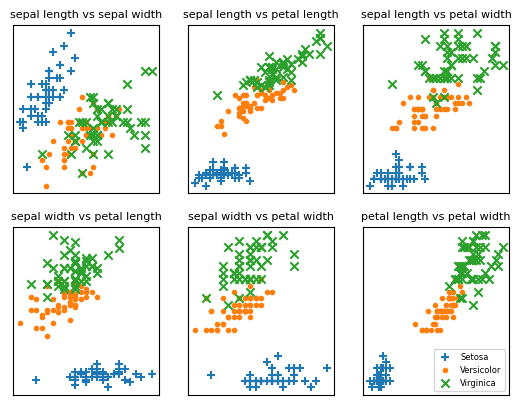

In [73]:
metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x']

fig, ax = plt.subplots(2, 3)
for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)

ax[-1][-1].legend(loc='lower right', prop={'size': 6})
plt.savefig('iris_scatter.png', dpi = 150)

### $\textbf{Separação dos dados para treinamento e teste}$

O conjunto de treinamento será formado pelos "vizinhos" que serão utilizados para classificar os pontos no conjunto de testes. Com atenção para o valor de $k$, o número de vizinhos. Caso o valor seja muito baixo ($k$ = 1), teremos uma influência muito grande dos $outliers$, caso seja muito alto ($k$ = 150), a previsão vai se limitar à classe mais comum no conjunto de dados. Para este caso, será utilizado $k$ = 5.

In [74]:
iris_train, iris_test = train_test_split(iris_data, test_size=0.3, random_state=12)

In [75]:
assert len(iris_train) == 0.7 * len(iris_data)
assert len(iris_test) == 0.3 * len(iris_data)

### $\textbf{Predição para o conjunto de dados}$

In [76]:
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label

    if predicted == actual:
        num_correct += 1

    confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(iris_test)

In [77]:
print(round(pct_correct,2)*100,'%', 'dos valores corretos')

98.0 % dos valores corretos


In [78]:
df_confusion = pd.DataFrame(confusion_matrix.values(), index=pd.MultiIndex.from_tuples(confusion_matrix.keys()), columns=['Count'])
display(df_confusion)

,,Count
Setosa,Setosa,20
Virginica,Virginica,11
Versicolor,Versicolor,13
Virginica,Versicolor,1


98% dos valores presente nas features de teste foram validadas de forma correta, issom implica uma previsão do modelo quase perfeita, o ponto fora da curva se dá em uma $versicolor$ em que ele prevê $virginica$.